In [157]:
import pandas as pd
import numpy as np
import random
import transformers
import torch
import dotenv
import os
import matplotlib.pyplot as plt
from scipy import stats

dotenv.load_dotenv()

True

In [158]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
    token=os.getenv('HF_TOKEN')
)

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [159]:
def make_problem(digits, format=None):
    if format is None:
        n = random.randint(10**(digits-1), 10**digits-1)
        return str(n), n
    elif format[0] == '+':
        p1 = make_problem(digits, format[1][0])
        p2 = make_problem(digits, format[1][1])
        return f"({p1[0]}+{p2[0]})", p1[1] + p2[1]
    elif format[0] == '-':
        p1 = make_problem(digits, format[1][0])
        p2 = make_problem(digits, format[1][1])
        return f"({p1[0]}-{p2[0]})", p1[1] - p2[1]
    elif format[0] == '*':
        p1 = make_problem(digits, format[1][0])
        p2 = make_problem(digits, format[1][1])
        return f"({p1[0]}*{p2[0]})", p1[1] * p2[1]
    
def make_problem_set(digits, format, num_problems):
    return pd.DataFrame([make_problem(digits, format) for _ in range(num_problems)], columns=['problem', 'correct_solution'])

In [160]:
def solve_problem_cot(problem, sys_prompt, cot_prompt):
    messages = [
    {"role": "system", "content": sys_prompt + ' ' + cot_prompt},
    {"role": "user", "content": problem},
    ]

    outputs = pipeline(
    messages,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    pad_token_id=pipeline.tokenizer.eos_token_id
    )

    return outputs[0]['generated_text'][-1]['content']

def solve_problem_set_cot(problem_set, sys_prompt, cot_prompt):
    solved = problem_set.copy()
    solved['solution'] = [solve_problem_cot(row['problem'], sys_prompt, cot_prompt) for _, row in problem_set.iterrows()]
    return solved

def solve_problem_fp(problem, sys_prompt, fp_prompt, max_toks=10):
    messages = [
    {"role": "system", "content": sys_prompt + ' ' + fp_prompt},
    {"role": "user", "content": problem},
    ]

    outputs = pipeline(
    messages,
    max_new_tokens=max_toks,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    pad_token_id=pipeline.tokenizer.eos_token_id
    )

    return outputs[0]['generated_text'][-1]['content']

def solve_problem_set_fp(problem_set, sys_prompt, fp_prompt):
    solved = problem_set.copy()
    solved['solution'] = [solve_problem_fp(row['problem'], sys_prompt=sys_prompt, fp_prompt=fp_prompt) for _, row in problem_set.iterrows()]
    return solved

In [161]:
def correct_rate(solution_set):
    df_with_correct = solution_set.copy()
    df_with_correct['correct'] = df_with_correct.apply(lambda x: str(x['correct_solution']) in x['solution'], axis=1)
    return df_with_correct

In [185]:
def bernoulli_std(mean, samples):
    return np.sqrt((mean*(1-mean))/samples)

def do_full_test(digits, format, sys_prompt, cot_prompt, fp_prompt, n):
    df = make_problem_set(digits, format, n)
    df_cot = solve_problem_set_cot(df, sys_prompt, cot_prompt)
    df_cot = correct_rate(df_cot)
    df_fp = solve_problem_set_fp(df, sys_prompt, fp_prompt)
    df_fp = correct_rate(df_fp)
    cot_mean = sum(df_cot['correct'])/n
    fp_mean = sum(df_fp['correct'])/n
    print(f"COT accuracy: {cot_mean} +- {2*bernoulli_std(cot_mean, n):.3f}\nFP accuracy: {fp_mean} +- {2*bernoulli_std(fp_mean, n):.3f}")
    return df_cot, df_fp
    

In [163]:
task_p = 'What is the value of this expression?'
cot_p_add = 'Think through your answer carefully, and show all your work.'
cot_p_mul = 'Think through your answer carefully, and show all your work.'
fp_p = 'Answer with only a number.'

n_samples = 50

In [164]:
results_add = []

for n in range(1, 20):
    results_add.append(do_full_test(n,
             ('+', (None, None)),
             task_p,
             cot_p_add,
             fp_p,
             n_samples))

COT accuracy: 1.0 +- 0.000
FP accuracy: 1.0 +- 0.000
COT accuracy: 1.0 +- 0.000
FP accuracy: 1.0 +- 0.000
COT accuracy: 0.98 +- 0.040
FP accuracy: 1.0 +- 0.000
COT accuracy: 0.98 +- 0.040
FP accuracy: 0.96 +- 0.055
COT accuracy: 0.86 +- 0.098
FP accuracy: 0.82 +- 0.109
COT accuracy: 0.72 +- 0.127
FP accuracy: 0.72 +- 0.127
COT accuracy: 0.4 +- 0.139
FP accuracy: 0.2 +- 0.113
COT accuracy: 0.38 +- 0.137
FP accuracy: 0.64 +- 0.136
COT accuracy: 0.44 +- 0.140
FP accuracy: 0.5 +- 0.141
COT accuracy: 0.12 +- 0.092
FP accuracy: 0.26 +- 0.124
COT accuracy: 0.14 +- 0.098
FP accuracy: 0.22 +- 0.117
COT accuracy: 0.12 +- 0.092
FP accuracy: 0.3 +- 0.130
COT accuracy: 0.12 +- 0.092
FP accuracy: 0.22 +- 0.117
COT accuracy: 0.14 +- 0.098
FP accuracy: 0.22 +- 0.117
COT accuracy: 0.08 +- 0.077
FP accuracy: 0.2 +- 0.113
COT accuracy: 0.06 +- 0.067
FP accuracy: 0.16 +- 0.104
COT accuracy: 0.1 +- 0.085
FP accuracy: 0.08 +- 0.077
COT accuracy: 0.1 +- 0.085
FP accuracy: 0.06 +- 0.067
COT accuracy: 0.08 +- 

In [165]:
results_mul = []

for n in range(1, 5):
    results_mul.append(do_full_test(n,
             ('*', (None, None)),
             task_p,
             cot_p_add,
             fp_p,
             n_samples))

COT accuracy: 1.0 +- 0.000
FP accuracy: 1.0 +- 0.000
COT accuracy: 0.8 +- 0.113
FP accuracy: 0.7 +- 0.130
COT accuracy: 0.08 +- 0.077
FP accuracy: 0.08 +- 0.077
COT accuracy: 0.0 +- 0.000
FP accuracy: 0.0 +- 0.000


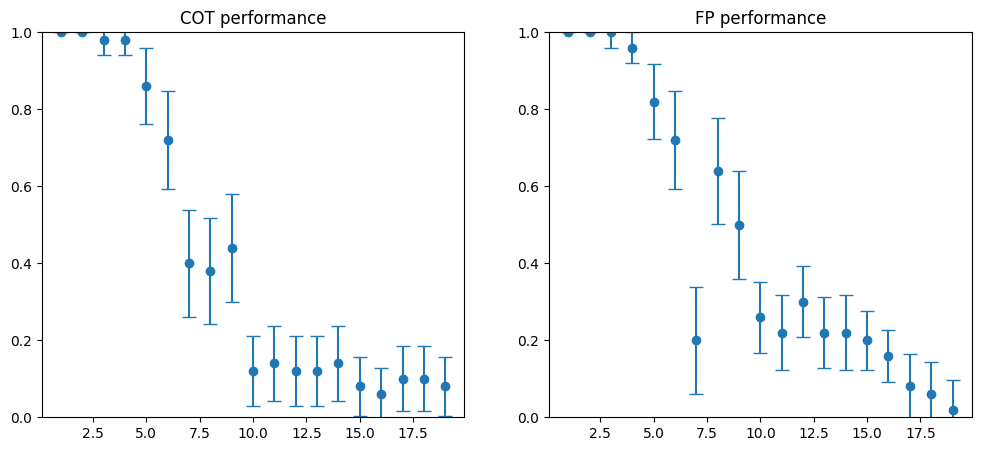

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.errorbar(
    x = range(1, len(results_add)+1),
    y = [sum(df_cot['correct'])/n_samples for df_cot, _ in results_add],
    yerr = [2*bernoulli_std(sum(df_cot['correct'])/n_samples, n_samples) for df_cot, _ in results_add],
    linestyle='',
    fmt='o',
    capsize=5
)
ax1.set_title('COT performance')
ax1.set_ylim(0, 1)
ax2.errorbar(
    x = range(1, len(results_add)+1),
    y = [sum(df_fp['correct'])/n_samples for _, df_fp in results_add],
    yerr = [2*bernoulli_std(sum(df_fp['correct'])/n_samples, n_samples) for df_fp, _ in results_add],
    linestyle='',
    fmt='o',
    capsize=5
)
ax2.set_title('FP performance')
ax2.set_ylim(0, 1)
plt.show()

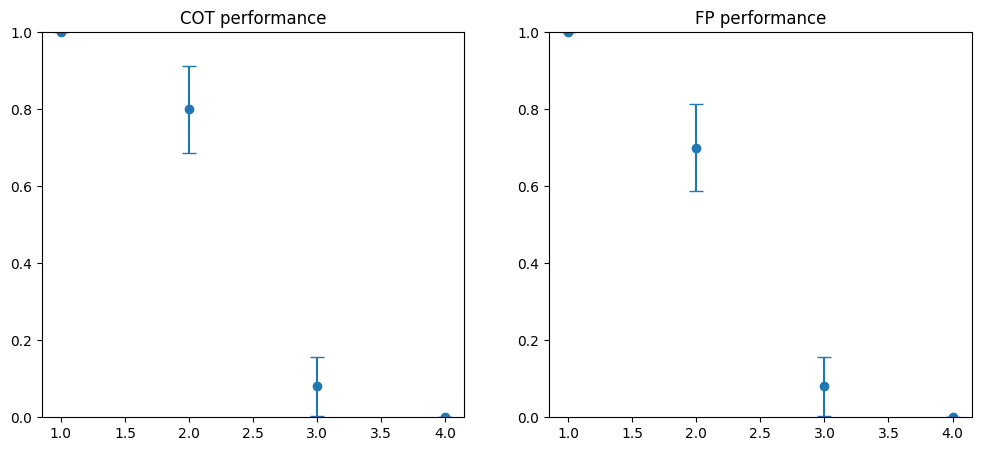

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.errorbar(
    x = range(1, len(results_mul)+1),
    y = [sum(df_cot['correct'])/n_samples for df_cot, _ in results_mul],
    yerr = [2*bernoulli_std(sum(df_cot['correct'])/n_samples, n_samples) for df_cot, _ in results_mul],
    linestyle='',
    fmt='o',
    capsize=5
)
ax1.set_title('COT performance')
ax1.set_ylim(0, 1)
ax2.errorbar(
    x = range(1, len(results_mul)+1),
    y = [sum(df_fp['correct'])/n_samples for _, df_fp in results_mul],
    yerr = [2*bernoulli_std(sum(df_fp['correct'])/n_samples, n_samples) for df_fp, _ in results_mul],
    linestyle='',
    fmt='o',
    capsize=5
)
ax2.set_title('FP performance')
ax2.set_ylim(0, 1)
plt.show()

In [235]:
from math import sqrt
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)

    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (max(p-lower_bound, 0), max(upper_bound-p, 0))

def do_fuller_test(digits_range, format, sys_prompt, cot_prompt, fp_prompt, n_samples):
    results = []
    cot_conf_ints = []
    fp_conf_ints = []
    for digits in digits_range:
        df = make_problem_set(digits, format, n_samples)

        df_cot = solve_problem_set_cot(df, sys_prompt, cot_prompt)
        df_cot = correct_rate(df_cot)
        cot_mean = sum(df_cot['correct'])/n_samples
        cot_lower, cot_upper = wilson(cot_mean, n_samples)
        cot_conf_ints.append((cot_lower, cot_upper))
        print(f"COT accuracy: between {cot_mean-cot_lower} and {cot_mean+cot_upper}")
        
        df_fp = solve_problem_set_fp(df, sys_prompt, fp_prompt)
        df_fp = correct_rate(df_fp)
        fp_mean = sum(df_fp['correct'])/n_samples
        fp_lower, fp_upper = wilson(fp_mean, n_samples)
        fp_conf_ints.append((fp_lower, fp_upper))
        print(f"FP accuracy: between {fp_mean-fp_lower} and {fp_mean+fp_upper}")

        results.append((df_cot, df_fp))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.errorbar(
        x = range(1, len(results)+1),
        y = [sum(df_cot['correct'])/n_samples for df_cot, _ in results],
        yerr = [[x[0] for x in cot_conf_ints], [x[1] for x in cot_conf_ints]],
        linestyle='',
        fmt='o',
        capsize=5
    )
    ax1.set_title('COT performance')
    ax1.set_ylim(0, 1)
    ax2.errorbar(
        x = range(1, len(results)+1),
        y = [sum(df_fp['correct'])/n_samples for _, df_fp in results],
        yerr = [[x[0] for x in fp_conf_ints], [x[1] for x in fp_conf_ints]],
        linestyle='',
        fmt='o',
        capsize=5
    )
    ax2.set_title('FP performance')
    ax2.set_ylim(0, 1)
    plt.show()
    return results

COT accuracy: between 0.7224598312333834 and 1.0
FP accuracy: between 0.0 and 0.2775401687666165
COT accuracy: between 0.7224598312333834 and 1.0
FP accuracy: between 0.01787574951572113 and 0.40415638549757205
COT accuracy: between 0.5958436145024277 and 0.9821242504842789
FP accuracy: between 0.0 and 0.2775401687666165
COT accuracy: between 0.3126695474501863 and 0.8318224187964901
FP accuracy: between 0.0 and 0.2775401687666165
COT accuracy: between 0.23658959361548726 and 0.7634104063845127
FP accuracy: between 0.0 and 0.2775401687666165


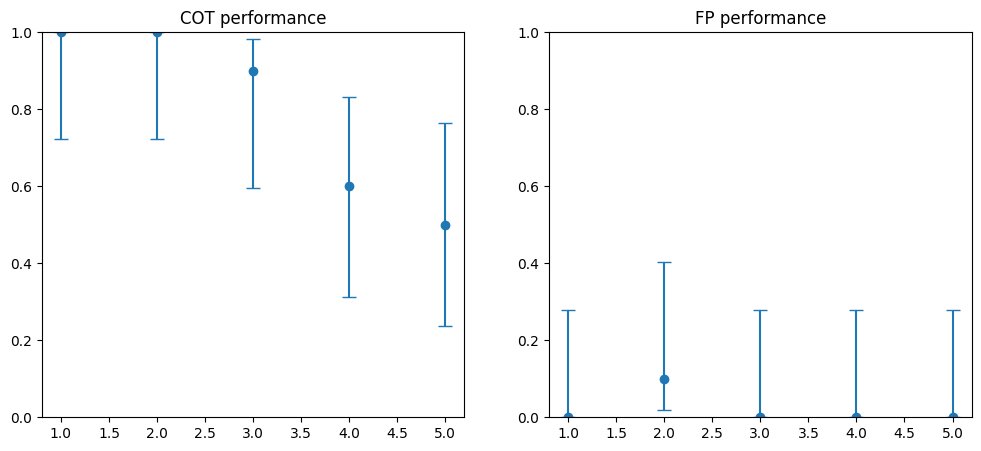

In [237]:
r = do_fuller_test(range(1, 6), ('+', (('+', (None, None)), ('+', (None, None)))), task_p, 'Think carefully and show all your work.', 'Answer with only a number.', 10)